<a href="https://colab.research.google.com/github/amansyayf/2023_ml-course/blob/main/%5Bhw%5Dautoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (9 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torchvision import transforms

%matplotlib inline

# DATASET_PATH = "../data"
# CHECKPOINT_PATH = "../saved_models/autoencoder"

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:

from sklearn.model_selection import train_test_split

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 100 # выберите размер латентного вектора (64-384)*4

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Encoder(nn.Module):
  def __init__(self, base_channel_size: int = 64, latent_dim: int = 100, act_fn: object = nn.GELU):
    super().__init__()
    c_hid = base_channel_size
    self.encoder = nn.Sequential(
        nn.Conv2d(3, c_hid, kernel_size=3, padding=1, stride=2),
        act_fn(),
        nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
        act_fn(),
        nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
        act_fn(),
        nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
        act_fn(),
        nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
        act_fn(),
        nn.Flatten(),
        nn.Linear(8 * 16 * c_hid, latent_dim),
    )
  def forward(self, x):
    return self.encoder(x)

In [ ]:
class Decoder(nn.Module):
  def __init__(self, base_channel_size: int = 64, latent_dim: int = 100, act_fn: object = nn.GELU):
    super().__init__()
    c_hid = base_channel_size
    self.linear = nn.Sequential(
            nn.Linear(latent_dim, 8 * 16 * c_hid),
            act_fn(),
        )
    self.net = nn.Sequential(
        nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
        act_fn(),
        nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
        act_fn(),
        nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
        act_fn(),
        nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
        act_fn(),
        nn.ConvTranspose2d(c_hid, 3, kernel_size=3, output_padding=1, padding=1, stride=2),
    )
  def forward(self, x):
    x = self.linear(x)
    x = x.reshape(x.shape[0], -1, 8, 8)
    x = self.net(x)
    return x

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self, base_channel_size: int = 64,
                 latent_dim: int = 100,
                 encoder_class: object = Encoder,
                 decoder_class: object = Decoder,
                 ):
        super().__init__()
        self.encoder = encoder_class(base_channel_size, latent_dim)
        self.decoder = decoder_class(base_channel_size, latent_dim)

    def forward(self, x):
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)
        x = x.permute(0, 3, 1, 2)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        reconstruction = reconstruction.permute(0, 2, 3, 1)
        return reconstruction, latent_code

    def get_decoder(self, latent_code):
        reconstruction = self.decoder(latent_code)
        reconstruction = reconstruction.permute(0, 2, 3, 1)
        return reconstruction


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = torch.nn.MSELoss()


autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_path = '/content/drive/MyDrive/machine_learning/dls_1/autoencoder_50ep.pth'


In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
def get_model(lr = 0.001, ):
  model = Autoencoder().to(device)

  return model, torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
class Dataloaders():
  def __init__(self):
    self.train_dl, self.val_dl = train_loader, val_loader

In [ ]:
class Learner():
  def __init__(self, model, opt, loss_func, dataloaders):

    self.model, self.opt, self.loss_func, self.dataloaders = model, opt, loss_func, dataloaders

    if os.path.isfile(checkpoint_path):
        print("Found pretrained model, loading...")
        load_checkpoint(checkpoint_path, self.model, self.opt)
    self.opt = torch.optim.Adam(model.parameters(), lr = 0.0006)

In [ ]:
learn = Learner(*get_model(), criterion, Dataloaders())

Found pretrained model, loading...
model loaded from /content/drive/MyDrive/machine_learning/dls_1/autoencoder_50ep.pth


In [ ]:
class CallBack():
  def begin_fit(self, learn):
    self.learn = learn
    return True
  def after_fit(self): return True
  def begin_epoch(self, epoch):
    self.epoch=epoch
    return True
  def begin_validate(self): return True
  def after_epoch(self, epoch): return True
  def begin_batch(self, xb, yb):
    self.xb, self.yb = xb, yb
    return True
  def after_loss(self, loss):
    self.loss = loss
    return True
  def after_train_loss(self, loss):
    pass
  def after_val_loss(self, loss):
    pass
  def after_backward(self): return True
  def after_step(self): return True

In [ ]:
class CheckPoint(CallBack):
  def __init__(self, path):
    self.path = path
    self.val_loss = None

  def begin_fit(self, learn):
    self.learn = learn

  def begin_epoch(self, epoch):
    self.val_losses_per_epoch = []

  def save_checkpoint(self, checkpoint_path):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': self.learn.model.state_dict(),
        'optimizer' : self.learn.opt.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

  def after_train_loss(self, loss):
    pass

  def after_val_loss(self, loss):
    self.val_losses_per_epoch.append(loss)

  def after_epoch(self, epoch):
    if self.val_loss is None:
      self.val_loss = np.mean(self.val_losses_per_epoch)
    else:
       if self.val_loss > np.mean(self.val_losses_per_epoch):
        self.val_loss = np.mean(self.val_losses_per_epoch)
        self.save_checkpoint(self.path)




In [ ]:
class DisplayProcess(CallBack):
  def __init__(self):
    self.train_losses = []
    self.val_losses = []

  def begin_fit(self, learn):
    self.learn = learn

    test_batch = next(iter(self.learn.dataloaders.val_dl))
    self.test_imgs = torch.stack((test_batch[0].float(),test_batch[1].float()), 0)
    self.test_imgs = self.test_imgs.to(device)
    with torch.no_grad():
      self.learn.model.eval()
      self.reconst_imgs, _ = self.learn.model(self.test_imgs)
      self.learn.model.train()




  def begin_epoch(self, epoch):
    self.train_losses_per_epoch = []
    self.val_losses_per_epoch = []


  def after_train_loss(self, loss):
    self.train_losses_per_epoch.append(loss)

  def after_val_loss(self, loss):
    self.val_losses_per_epoch.append(loss)


  def get_imgs(self, epoch):
    if epoch % 3 == 0:
      self.test_imgs = self.test_imgs.to(device)
      with torch.no_grad():
        self.learn.model.eval()
        self.reconst_imgs, _ = self.learn.model(self.test_imgs)
        self.learn.model.train()


  def after_epoch(self, epoch):
      self.train_losses.append(np.mean(self.train_losses_per_epoch))
      self.val_losses.append(np.mean(self.val_losses_per_epoch))

      self.get_imgs(epoch)

      clear_output(True)


      fig, axes = plt.subplots(2, 2, figsize=(10, 7))


      axes[0][0].set_title('Origin')
      axes[0][0].imshow(self.test_imgs[0].cpu())

      axes[0][1].set_title('Reconstructed')
      axes[0][1].imshow(self.reconst_imgs[0].cpu())

      axes[1][0].set_title('Origin')
      axes[1][0].imshow(self.test_imgs[1].cpu())

      axes[1][1].set_title('Reconstructed')
      axes[1][1].imshow(self.reconst_imgs[1].cpu())

      plt.figure(figsize = (10, 7))
      plt.title('Loss')
      plt.plot(self.train_losses, label='train')
      plt.plot(self.val_losses, label='validation')
      plt.legend()
      plt.grid(True)
      plt.show()

In [ ]:
class CallbackHandler():
  def __init__(self, cbs=None):
    self.cbs = cbs if cbs else []

  def begin_fit(self, learn):
    self.learn, self.in_train = learn, True
    learn.stop = False
    for cb in self.cbs:  cb.begin_fit(learn)

  def begin_epoch(self, epoch):
    self.learn.model.train()
    self.in_train = True
    for cb in self.cbs: cb.begin_epoch(epoch)

  def begin_batch(self, xb):
    pass

  def after_loss(self, loss):
    if self.in_train:
      for cb in self.cbs: cb.after_train_loss(loss)
    else:
      for cb in self.cbs: cb.after_val_loss(loss)





  def begin_validate(self,):
    self.learn.model.eval()
    self.in_train = False

    for cb in self.cbs:  cb.begin_validate()




  def after_backward(self,):
    return self.in_train

  def after_step(self,):
    return self.in_train

  def do_stop(self,):
    return False

  def after_epoch(self, epoch):
    for cb in self.cbs: cb.after_epoch(epoch)
    return True

  def after_fit(self):
    for cb in self.cbs: cb.after_fit()


In [ ]:
cbs = [CheckPoint(checkpoint_path), DisplayProcess()]
callbacks = CallbackHandler(cbs)

In [ ]:
def one_batch(xb, cb):
  cb.begin_batch(xb)
  x_hat, _ = cb.learn.model(xb)
  loss = F.mse_loss(xb.permute(0, 3, 1, 2), x_hat.permute(0, 3, 1, 2), reduction="none")
  loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
  cb.after_loss(loss.item())
  if cb.after_backward(): loss.backward()
  if cb.after_backward():
    cb.learn.opt.step()
  if cb.after_step(): cb.learn.opt.zero_grad()

def all_batches(dl, cb):
  for xb in dl:
    xb = xb.float()
    xb = xb.to(device)

    one_batch(xb, cb)
    if cb.do_stop(): return

def fit(epochs, learn, cb):
  cb.begin_fit(learn)
  for epoch in range(epochs):
    cb.begin_epoch(epoch)
    all_batches(learn.dataloaders.train_dl, cb)

    cb.begin_validate()
    with torch.no_grad():
      all_batches(learn.dataloaders.val_dl, cb)
    if cb.do_stop() or not cb.after_epoch(epoch): break
  cb.after_fit()

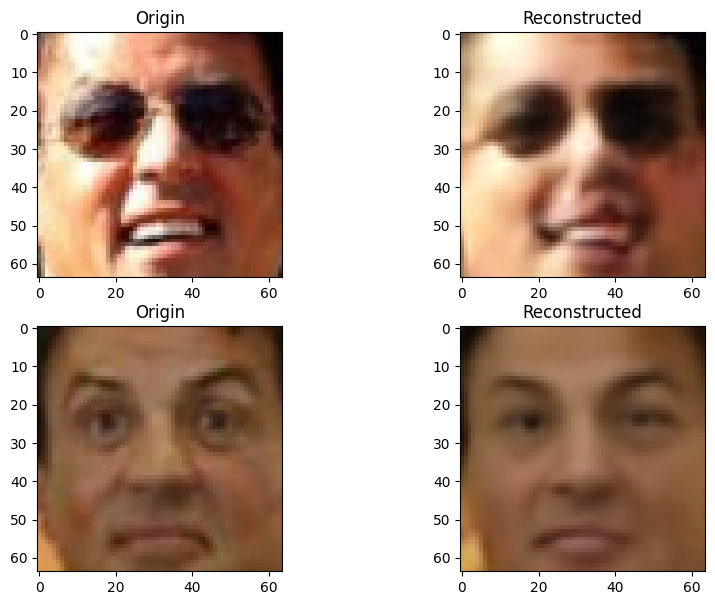

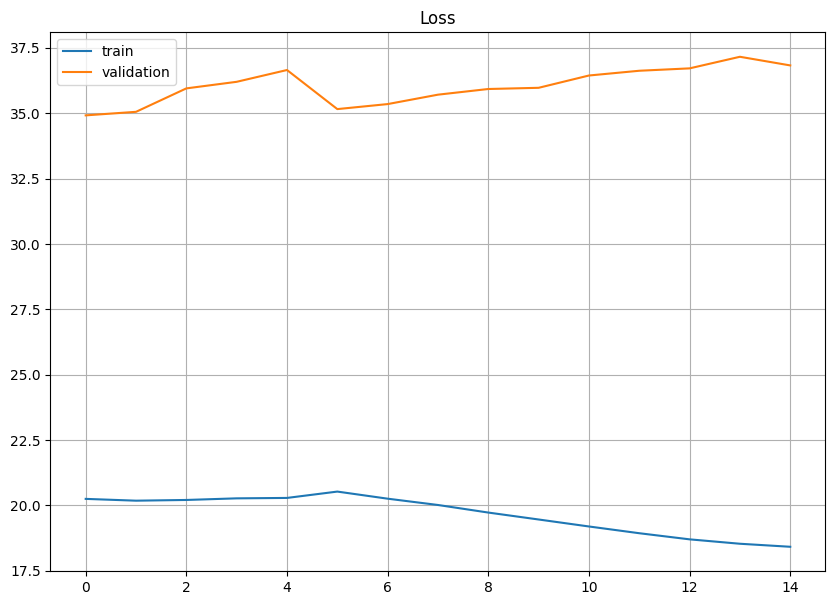

In [ ]:
fit(epochs = 15, learn = learn, cb = callbacks)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

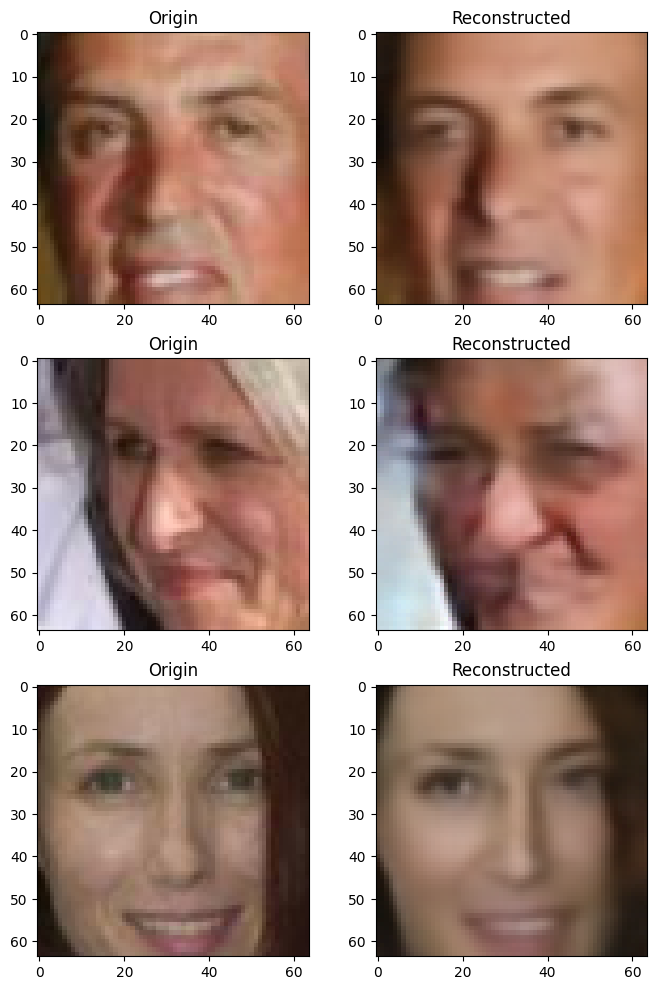

In [ ]:
test_batch = next(iter(learn.dataloaders.val_dl))
test_imgs = torch.stack((test_batch[2].float(), test_batch[3].float(), test_batch[4].float()), 0)
test_imgs = test_imgs.to(device)
with torch.no_grad():
  learn.model.eval()
  reconst_imgs, _ = learn.model(test_imgs)
  learn.model.train()
fig, axes = plt.subplots(3, 2, figsize=(8, 12))


axes[0][0].set_title('Origin')
axes[0][0].imshow(test_imgs[0].cpu())

axes[0][1].set_title('Reconstructed')
axes[0][1].imshow(reconst_imgs[0].cpu())

axes[1][0].set_title('Origin')
axes[1][0].imshow(test_imgs[1].cpu())

axes[1][1].set_title('Reconstructed')
axes[1][1].imshow(reconst_imgs[1].cpu())

axes[2][0].set_title('Origin')
axes[2][0].imshow(test_imgs[2].cpu())

axes[2][1].set_title('Reconstructed')
axes[2][1].imshow(reconst_imgs[2].cpu())

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

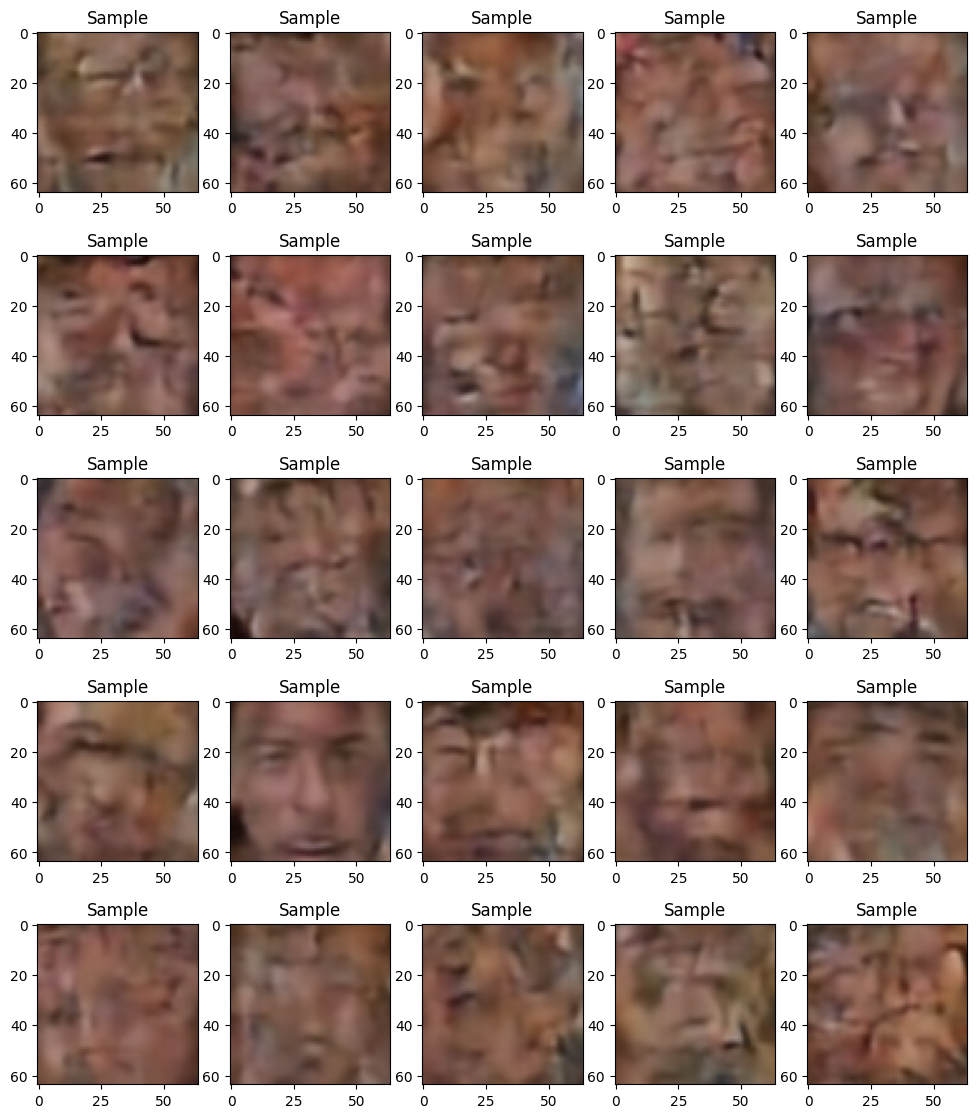

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
# np.random.seed(111)
z = np.random.randn(25, 100)
z = torch.from_numpy(z.astype(np.float32)).to(device)
output = learn.model.get_decoder(z)
fig, axes = plt.subplots(5, 5, figsize=(12, 14))

for i in range(5):
  for j in range(5):
    axes[i][j].set_title('Sample')
    axes[i][j].imshow(output[5*i+j].detach().cpu())




## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
male_smile = attrs[(attrs['Male']>0) & (attrs['Smiling']>0.5)].index
male_not_smile = attrs[(attrs['Male']>0) & (attrs['Smiling']<-0.5)].index

In [ ]:
print(male_smile.shape)
print(male_not_smile.shape)

(2404,)
(5184,)


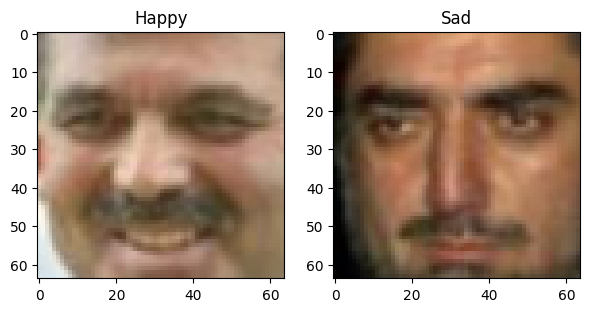

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

axes[0].set_title('Happy')
axes[0].imshow(data[male_smile[10]])
axes[1].set_title('Sad')
axes[1].imshow(data[male_not_smile[10]])

In [ ]:
smile_vectors = []
for ind in male_smile:

  with torch.no_grad():
    learn.model.eval()
    img = torch.from_numpy(data[ind])[None, :, :, :]
    _, vec = learn.model(img.float().to(device))
    learn.model.train()
    smile_vectors.append(vec.cpu().numpy())

not_smile_vectors = []
for ind in male_not_smile:
  with torch.no_grad():
    learn.model.eval()
    img = torch.from_numpy(data[ind])[None, :, :, :]
    _, vec = learn.model(img.float().to(device))
    learn.model.train()
    not_smile_vectors.append(vec.cpu().numpy())

In [ ]:
smile_vec = np.mean(smile_vectors, axis=0) - np.mean(not_smile_vectors, axis=0)

In [ ]:
not_smile_vectors[7].shape

(1, 100)

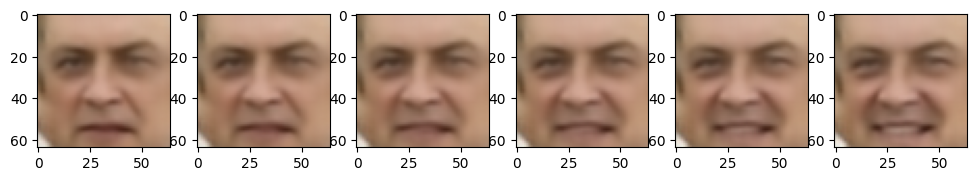

In [ ]:

fig, axes = plt.subplots(1, 6, figsize=(12, 18))

for i in range(6):
  z = not_smile_vectors[19] + i*smile_vec/5
  z = torch.from_numpy(z.astype(np.float32)).to(device)
  output = learn.model.get_decoder(z)
  axes[i].imshow(output[0].detach().cpu())

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torchvision import transforms

In [2]:
class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image

In [3]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
#     transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=mnist_transformations, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=mnist_transformations, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 197529961.54it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 109427004.36it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 181310072.27it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20180644.88it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [5]:
class VAE(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distrubution = torch.distributions.normal.Normal(loc=self._initial_mu, scale=self._initial_sigma)
        input_dim = np.prod(input_shape)
        self.encoder = nn.Sequential(*[
          nn.Conv2d(1, intermediate_dims[0], kernel_size=3, padding=1, stride=2),
          nn.GELU(),
          nn.Conv2d(intermediate_dims[0], intermediate_dims[0], kernel_size=3, padding=1),
          nn.GELU(),
          nn.Conv2d(intermediate_dims[0], intermediate_dims[0], kernel_size=3, padding=1, stride=2),
          nn.GELU(),
          nn.Flatten(),
          nn.Linear(7 * 7 * intermediate_dims[0], intermediate_dims[1]),

        ])

        self.mu_repr = nn.Linear(intermediate_dims[1], latent_dim)
        self.log_sigma_repr = nn.Linear(intermediate_dims[1], latent_dim)


        self.linear = nn.Sequential(*[
            nn.Linear(latent_dim, 7 * 7 * intermediate_dims[0]),
            nn.GELU(),
        ])
        self.decoder = nn.Sequential(*[

        nn.ConvTranspose2d(intermediate_dims[0], intermediate_dims[0], kernel_size=3, output_padding=1, padding=1, stride=2),
        nn.GELU(),
        nn.Conv2d(intermediate_dims[0], intermediate_dims[0], kernel_size=3, padding=1),
        nn.GELU(),
        nn.ConvTranspose2d(intermediate_dims[0], 1, kernel_size=3, output_padding=1, padding=1, stride=2),
        nn.Sigmoid()
        ])

    def encode(self, x):
      latent_repr = self.encoder(x)
      mu_values = self.mu_repr(latent_repr)
      log_sigma_values = self.log_sigma_repr(latent_repr)
      return mu_values, log_sigma_values

    def decode(self, z):
      z = self.linear(z)
      z = z.reshape(z.shape[0], -1, 7, 7)
      reconstruction = self.decoder(z)
      return reconstruction

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            raw_sample = torch.rand_like(mu)
            sample = torch.exp(logsigma) * raw_sample + mu
            return sample
        else:

            return mu



    def forward(self, x):
        mu, logsigma = self.encode(x)


        latent_sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent_sample)

        return mu, logsigma, reconstruction

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
device

device(type='cuda', index=0)

In [9]:
from torchsummary import summary

In [10]:

example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = VAE([64, 32], 10, example_x.shape).to(device)



summary(model, example_x.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
              GELU-2           [-1, 64, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          36,928
              GELU-4           [-1, 64, 14, 14]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              GELU-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                   [-1, 32]         100,384
            Linear-9                   [-1, 10]             330
           Linear-10                   [-1, 10]             330
           Linear-11                 [-1, 3136]          34,496
             GELU-12                 [-1, 3136]               0
  ConvTranspose2d-13           [-1, 64, 14, 14]          36,928
             GELU-14           [-1, 64,

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [11]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = 0.5*torch.mean(torch.sum(mu.pow(2) + torch.exp(logsigma) - logsigma -1., dim=-1))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss_func = torch.nn.modules.loss.BCELoss()
    loss = 28*28*loss_func(reconstruction, x)
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return (log_likelihood(x, reconstruction) + KL_divergence(mu, logsigma))/2./28./28.

И обучим модель:

In [12]:

example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

criterion = loss_vae

autoencoder = VAE([64, 132], 10, example_x.shape).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

In [13]:
import tqdm

In [ ]:


def train(num_epochs, model, loss_fn, opt):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            mu, logsigma, reconstruction = model(batch_x)


            loss = loss_fn(batch_x, mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss/(len(train_loader.dataset))
            bce_acc += log_likelihood(batch_x, reconstruction)/(len(train_loader.dataset))
            kl_acc += KL_divergence(mu, logsigma)/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))


    return epochs, figs, latent_distrs

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
epochs, figs, latent_distrs = train(15, autoencoder, criterion, optimizer)

<ipython-input-15-d5d40d1372f5>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch_num in tqdm.tnrange(num_epochs):


  0%|          | 0/15 [00:00<?, ?it/s]

<ipython-input-15-d5d40d1372f5>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch num: 0
Training loss=0.0031, KL divergence=0.2253, BCE Loss=4.7108


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch num: 5
Training loss=0.0020, KL divergence=0.1910, BCE Loss=2.8979


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch num: 10
Training loss=0.0019, KL divergence=0.1959, BCE Loss=2.7266


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
path = '/content/drive/MyDrive/machine_learning/dls_1/vae.pth'

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

save_checkpoint(path, autoencoder, optimizer)

model saved to /content/drive/MyDrive/machine_learning/dls_1/vae.pth


Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
path = '/content/drive/MyDrive/machine_learning/dls_1/vae.pth'

In [16]:

def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [17]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

autoencoder = VAE([64, 132], 10, example_x.shape).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

In [19]:
load_checkpoint(path, autoencoder, optimizer)

model loaded from /content/drive/MyDrive/machine_learning/dls_1/vae.pth


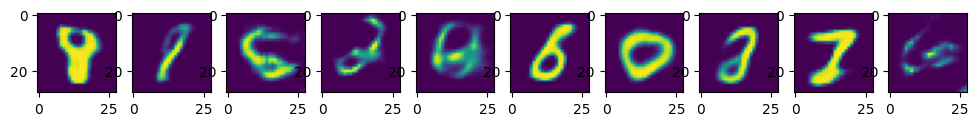

In [20]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 10) for i in range(10)])
z = torch.from_numpy(z.astype(np.float32)).to(device)
output = autoencoder.decode(z)
fig, axes = plt.subplots(1, 10, figsize=(12, 14))
for i in range(10):
  axes[i].imshow(output[i][0].detach().cpu())

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [21]:
latent_distrs = []
labels = []
for batch_x, batch_label in test_loader:
  batch_x = batch_x.to(device)
  mu, logsigma = autoencoder.encode(batch_x)

  latent_distrs.append([mu.cpu().detach().numpy(), logsigma.cpu().detach().numpy()])


  labels.append(batch_label.cpu().detach().numpy())




In [22]:
labels.pop()
latent_distrs.pop()

[array([[ 6.11518621e-01,  8.86154830e-01,  9.41207886e-01,
         -8.62536967e-01,  5.59220195e-01,  7.94740021e-01,
          5.42085946e-01,  6.85767114e-01, -5.30633852e-02,
          3.42242420e-04],
        [ 7.70916566e-02,  5.28271139e-01,  1.47945809e+00,
          8.27109814e-01, -6.80149734e-01,  5.39720282e-02,
          1.89692862e-02,  6.60409212e-01, -7.55723238e-01,
          3.19476545e-01],
        [ 7.57633984e-01,  5.00575125e-01,  5.97113788e-01,
          7.44209468e-01, -3.27749521e-01,  8.76249194e-01,
         -2.89713323e-01,  4.26552087e-01, -5.49502015e-01,
         -2.77930908e-02],
        [ 5.44201016e-01,  3.45695764e-01, -2.44977623e-01,
         -4.39503402e-01,  3.36834967e-01, -1.45581260e-01,
          1.59904277e+00, -1.27411556e+00,  7.38928854e-01,
          1.13380170e+00],
        [ 1.66134059e-01,  1.96657255e-02, -1.45660174e+00,
          7.38605857e-01,  8.05686414e-01,  6.53944433e-01,
         -6.30678758e-02, -3.09248008e-02, -1.394857

In [24]:
labels = np.array(labels, dtype=int).flatten()

In [25]:
labels.shape

(9984,)

In [26]:
np.array(latent_distrs).shape

(312, 2, 32, 10)

In [27]:
latent_distrs = torch.from_numpy(np.array(latent_distrs))
latent_distrs = latent_distrs.permute(0, 2, 1, 3)
latent_distrs = latent_distrs.numpy()
latent_distrs = latent_distrs.reshape(9984, 20)

In [29]:
np.array(latent_distrs).shape

(9984, 20)

In [30]:
from sklearn.manifold import TSNE
import seaborn as sns

In [31]:
tsne = TSNE()

In [32]:
proj_2d = tsne.fit_transform (latent_distrs)

In [33]:
proj_2d = tsne.fit_transform (latent_distrs)
tsne_df = pd.DataFrame({'tsne_1': proj_2d[:, 0], 'tsne_2': proj_2d[:, 1], 'label': labels})

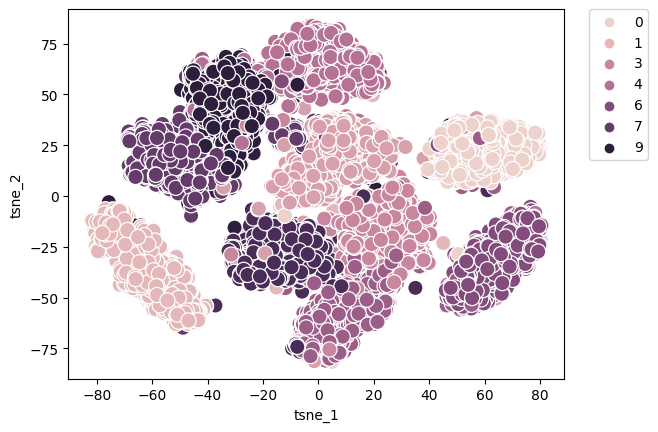

In [34]:
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_df, ax=ax,s=120)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [35]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape

    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

In [93]:
class CVAE(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distrubution = torch.distributions.normal.Normal(
            loc=self._initial_mu, scale=self._initial_sigma)
        input_dim = np.prod(input_shape)

        self.encoder = nn.Sequential(*[
                Flatten(),
                nn.Linear(input_dim + 10, intermediate_dims[0]),
                nn.ReLU(),
                nn.BatchNorm1d(intermediate_dims[0]),
                nn.Dropout(0.3),
                nn.Linear(intermediate_dims[0], intermediate_dims[1]),
                nn.ReLU(),
                nn.BatchNorm1d(intermediate_dims[1]),
                nn.Dropout(0.3)
            ])

        self.mu_repr = nn.Linear(intermediate_dims[1], latent_dim)
        self.log_sigma_repr = nn.Linear(intermediate_dims[1], latent_dim)


        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim + 10, intermediate_dims[1]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[1], intermediate_dims[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], input_dim),
            nn.Sigmoid(),
            RestoreShape(input_shape)
        ])


    def encode(self, x, class_num):
      label = F.one_hot(torch.tensor(class_num), num_classes=10)
      x = x.view(-1, 1*28*28)
      x = torch.cat((x,label),dim=1)
      latent_repr = self.encoder(x)
      mu_values = self.mu_repr(latent_repr)
      log_sigma_values = self.log_sigma_repr(latent_repr)
      return mu_values, log_sigma_values, class_num

    def decode(self, z, class_num):
      label = F.one_hot(torch.tensor(class_num), num_classes=10)
      z = torch.cat((z, label),dim=1)
      reconstruction = self.decoder(z)
      return reconstruction

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            raw_sample = torch.rand_like(mu)
            sample = torch.exp(logsigma) * raw_sample + mu
            return sample
        else:

            return mu



    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)


        latent_sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent_sample, class_num)

        return mu, logsigma, reconstruction

In [98]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

loss = loss_vae

cvae = CVAE([256, 126], 10, example_x.shape).to(device)

optimizer = torch.optim.Adam(cvae.parameters(), lr=3e-3)

In [101]:
import tqdm

def train(num_epochs, model, loss_fn, opt):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            batch_label = batch_label.to(device)
            mu, logsigma, reconstruction = model(batch_x, batch_label)


            loss = loss_fn(batch_x, mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss/(len(train_loader.dataset))
            bce_acc += log_likelihood(batch_x, reconstruction)/(len(train_loader.dataset))
            kl_acc += KL_divergence(mu, logsigma)/(len(train_loader.dataset))

        if epoch_num % 3 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))


    return epochs, figs, latent_distrs

In [102]:
train(15, cvae, loss, optimizer)

<ipython-input-101-67dc42b97e30>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch_num in tqdm.tnrange(num_epochs):


  0%|          | 0/15 [00:00<?, ?it/s]

<ipython-input-101-67dc42b97e30>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):


  0%|          | 0/1875 [00:00<?, ?it/s]

<ipython-input-93-3692ebc74b71>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = F.one_hot(torch.tensor(class_num), num_classes=10)
<ipython-input-93-3692ebc74b71>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = F.one_hot(torch.tensor(class_num), num_classes=10)


Epoch num: 0
Training loss=0.0022, KL divergence=0.1383, BCE Loss=3.2780


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch num: 3
Training loss=0.0020, KL divergence=0.1466, BCE Loss=2.9440


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch num: 6
Training loss=0.0019, KL divergence=0.1484, BCE Loss=2.8439


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch num: 9
Training loss=0.0019, KL divergence=0.1495, BCE Loss=2.7892


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch num: 12
Training loss=0.0019, KL divergence=0.1502, BCE Loss=2.7517


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

([], [], [])

In [103]:
cvae_path = '/content/drive/MyDrive/machine_learning/dls_1/cvae.pth'

In [104]:
save_checkpoint(cvae_path, cvae, optimizer)

model saved to /content/drive/MyDrive/machine_learning/dls_1/cvae.pth


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

<ipython-input-93-3692ebc74b71>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = F.one_hot(torch.tensor(class_num), num_classes=10)


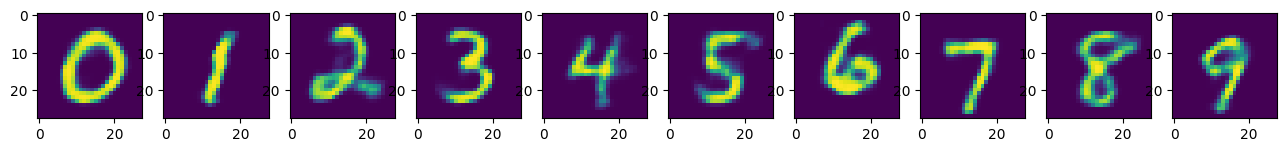

In [105]:
z = np.array(np.random.normal(0, 1, 10))
z = np.array([z for i in range(10)])
z = torch.from_numpy(z.astype(np.float32)).to(device)
i = np.arange(10)
i = torch.tensor(i).to(device)
output = cvae.decode(z, i)
fig, axes = plt.subplots(1, 10, figsize=(16, 18))
for i in range(10):
  axes[i].imshow(output[i][0].detach().cpu())

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [106]:
latent_distrs = []
labels = []
for batch_x, batch_label in test_loader:
  batch_x = batch_x.to(device)
  batch_label = batch_label.to(device)
  mu, logsigma, _= cvae.encode(batch_x, batch_label)

  latent_distrs.append([mu.cpu().detach().numpy(), logsigma.cpu().detach().numpy()])


  labels.append(batch_label.cpu().detach().numpy())



<ipython-input-93-3692ebc74b71>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = F.one_hot(torch.tensor(class_num), num_classes=10)


In [107]:
labels.pop()
latent_distrs.pop()

labels = np.array(labels, dtype=int).flatten()

latent_distrs = torch.from_numpy(np.array(latent_distrs))
latent_distrs = latent_distrs.permute(0, 2, 1, 3)
latent_distrs = latent_distrs.numpy()
latent_distrs = latent_distrs.reshape(9984, 20)

In [108]:
tsne = TSNE()

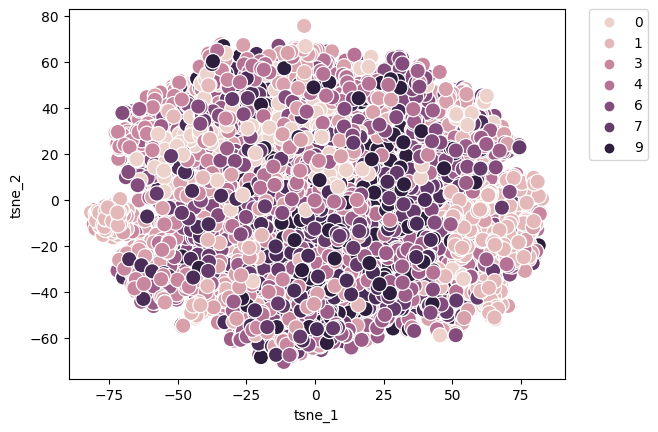

In [109]:
proj_2d = tsne.fit_transform (latent_distrs)
tsne_df = pd.DataFrame({'tsne_1': proj_2d[:, 0], 'tsne_2': proj_2d[:, 1], 'label': labels})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_df, ax=ax,s=120)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>